## Детекция объектов.

### О задании

Напишем с нуля архитектуру для детекции, а также воспользуемся готовым решением.
Будем использовать датасет с игральными картами. Научимся искать и выделять на фотографиях несколько типов карт.

## Данные


In [ ]:
# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
import glob
import shutil
from pathlib import Path
from xml.etree import ElementTree as ET

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.transforms as T
from matplotlib.patches import Rectangle
from PIL import Image
from torch import nn
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm

!unzip -q data.zip

--2025-11-29 10:38:30--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2025-11-29 10:38:31--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  36.61M  --.-KB/s    in 0.1s    

2025-11-29 10:38:31 (274 MB/s) - ‘data.zip’ saved [38392108/38392108]



Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):

        cl = class_dict[member.find("name").text]
        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)
        res = [xmin, ymin, xmax, ymax, cl]

        bboxes.append(res)

    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):

        name = self.filenames[idx]
        image = np.array(Image.open(name))
        bboxes = get_xml_data(name, self.root, self.class_dict)


        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        name = self.filenames[idx]
        return name, get_xml_data(name, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    # Вот тут мы говорим что хотим pascal_voc
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [ ]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)


Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели.

In [ ]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']

    for i, ax in enumerate(axes.reshape(-1)):
        ax.axis(False)

        if i >= len(images):
            break

        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * std + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)

        for bbox in bboxes[i]:
        # Вот тут нарисуйте бибоксы
          xmin, ymin, xmax, ymax, cl = bbox
          color = colors[int(cl)]
          rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor=color, facecolor='none')
          ax.add_patch(rect)

          ax.text(xmin, ymin - 7, train_ds.class_dict_inv[cl], color=color, fontsize=12, weight='bold')



    fig.tight_layout()
    plt.show()

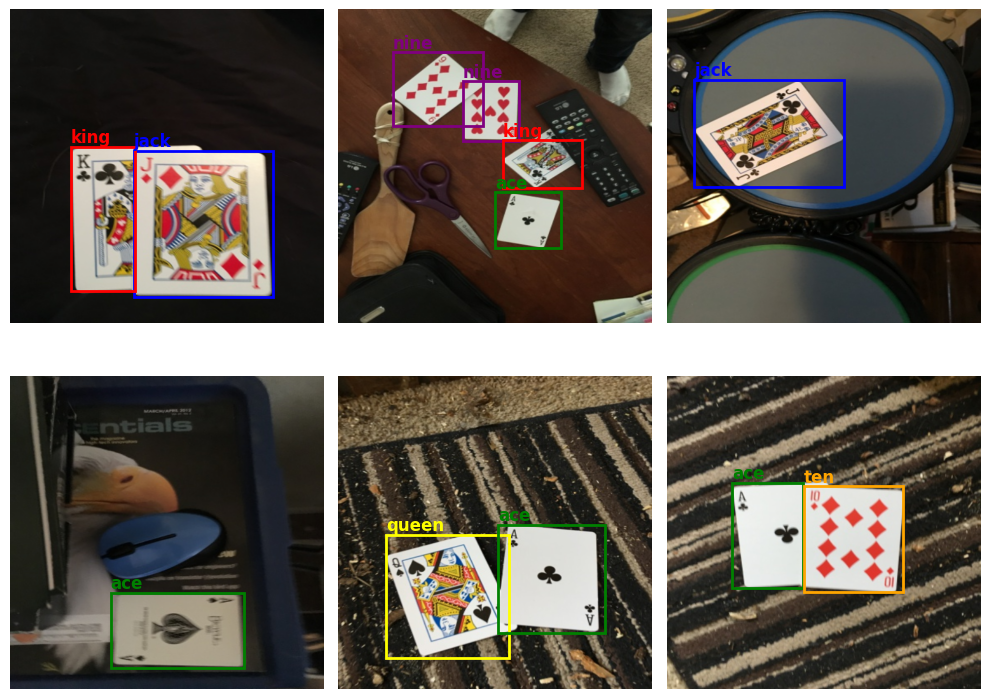

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])


## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать.

Это функция принимает на вход лист прямоугольников и возвращает тензор размера Bx6x16x16. Первая размерность - это количество примеров в батче. Вторая -- "каналы", суть которых написана чуть ниже. Далее идут две пространственные размерности, это сетка 16 на 16. Зафиксируем порядок координат как (y, x) для этой сетки 16 на 16.

В шести "каналах" у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "гиперпиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # ширина и высота бибокса могут превышать размеры гиперпикселя
        # поэтому их мы нормируем на полноценные 512
        w_box =  (xmax - xmin) / 512
        h_box =  (ymax - ymin) / 512

        # Посчитайем координаты центра и сдвиги
        cx = (xmin + xmax) / 2
        cy = (ymin + ymax) / 2

        cx_idx = (cx // 32).long()
        cy_idx = (cy // 32).long()

        cx_box = (cx - cx_idx.float() * 32) / 32
        cy_box = (cy - cy_idx.float() * 32) / 32

        # cy_idx, потом cx_idx
        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже можно увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

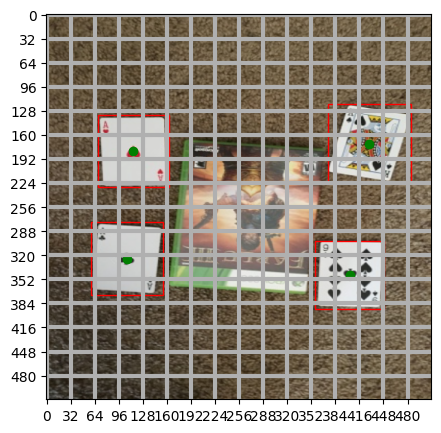

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

Реализуем обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function мы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.




In [ ]:
from typing import List


def decode_prediction(pred, upsample=32, threshold=0.7) -> List[List[List[float]]]:
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    result = []

    for i in range(b):
        bboxes = []
        for y in range(h):
            for x in range(w):
                cell = pred[i, :, y, x]
                conf = cell[4].item()
                if conf >= threshold:

                  if c == 6:
                      cls = int(cell[5].item())
                  else:
                      cls = int(torch.argmax(cell[5:]).item())

                  w_box = cell[2].item()
                  h_box = cell[3].item()

                  cx = (x + cell[0].item()) * 32
                  cy = (y + cell[1].item()) * 32

                  xmin = int(cx - w_box * img_w / 2)
                  ymin = int(cy - h_box * img_h / 2)
                  xmax = int(cx + w_box * img_w / 2)
                  ymax = int(cy + h_box * img_h / 2)

                  bboxes.append([xmin, ymin, xmax, ymax, cls])
        result.append(bboxes)

    return result


Реализуем модель. Первым делом применим первые 4 блока (до layer4 включительно, можно при помощи ```list(model.children())[:-2]```) ResNet50. Далее добавим несколько блоков (Conv2D, BatchNorm2D, ReLU).

In [ ]:
C =  6
class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.head = nn.Sequential(*list(model.children())[:-2])

        self.head1 = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 5 + C, kernel_size=3, padding=1),
            nn.Sigmoid())

    def forward(self, img):
        x = self.head(img)
        x = self.head1(x)
        return x

## Функция потерь.



In [ ]:
def special_loss(pred, target, C=C):
    mask = target[:, 4] == 1

    mse = nn.MSELoss(reduction="sum")
    pred_loc = torch.masked_select(pred[:, 0:2], mask.unsqueeze(1))
    targ_loc = torch.masked_select(target[:, 0:2], mask.unsqueeze(1))
    localization_loss = mse(pred_loc, targ_loc)

    pred_wh = torch.masked_select(pred[:, 2:4], mask.unsqueeze(1))
    targ_wh = torch.masked_select(target[:, 2:4], mask.unsqueeze(1))
    box_loss = mse(torch.sqrt(pred_wh), torch.sqrt(targ_wh))

    ce = nn.CrossEntropyLoss(reduction="sum")
    arr = []
    for idx in range(C):
        ch = torch.masked_select(pred[:, 5 + idx], mask)
        arr.append(ch)
    pred_cl = torch.stack(arr, dim=1)
    targ_cl = torch.masked_select(target[:, 5], mask).long()
    classification_loss = ce(pred_cl, targ_cl)

    bce = nn.BCELoss(reduction="sum")
    conf_loss1 = bce(torch.masked_select(pred[:, 4], mask),
                            torch.masked_select(target[:, 4], mask))
    conf_loss0 = bce(torch.masked_select(pred[:, 4], ~mask),
                            torch.masked_select(target[:, 4], ~mask))
    confidence_loss = conf_loss1 + 0.1 * conf_loss0

    return localization_loss + box_loss + classification_loss + confidence_loss

# Обучение


In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS =  15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        imgs = batch["image"].to(device)
        target = batch["target"].to(device)
        opt.zero_grad()
        pred = model(imgs)
        loss = special_loss(pred, target)
        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())


    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 99.763;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 46.817;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 37.795;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 34.604;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 32.635;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 31.675;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 29.896;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 27.990;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 27.319;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 26.625;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 26.164;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 25.202;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 25.111;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 26.099;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 26.365;


Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
img = batch["image"].to(device)
pred = model(img).cpu()

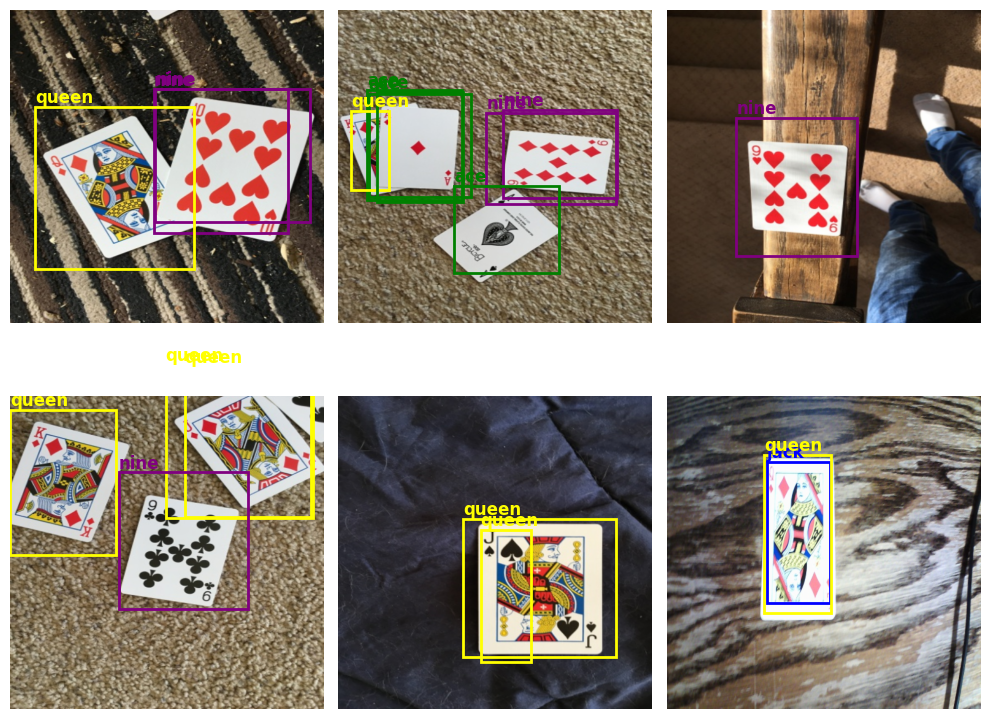

In [ ]:
bboxes = decode_prediction(pred, threshold=0.1)
visualize(img.cpu(), bboxes)



Результат сильно так себе. Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.).

Да, результат не очень, модель путает всех королей и вальтов с дамоми, но тузы и девятки определяет хорошо

## Прикручиваем NMS :^)



In [ ]:
def IoU(bbox1, bbox2):
    w = min(bbox1[2], bbox2[2]) - max(bbox1[0], bbox2[0])
    h = min(bbox1[3], bbox2[3]) - max(bbox1[1], bbox2[1])
    b1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    b2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])

    if w <= 0 or h <= 0:
        return 0
    return w * h / (b1_area + b2_area - w * h)

In [ ]:
def NMS(bboxes, threshold):
    result = []
    for card in range(6):
      bboxes = [box for box in bboxes if b[5] == card]
      bboxes_copy = bboxes.copy()
      bboxes = sorted(bboxes, key=lambda x: x[4])[::-1]
      for i in range(len(bboxes)):
        for j in range(i + 1, len(bboxes)):
            if bboxes[j] in bboxes_copy and IoU(bboxes[i], bboxes[j]) > threshold:
                bboxes_copy.remove(bboxes[j])

      result.extend([xmin, ymin, xmax, ymax, cls]
          for xmin, ymin, xmax, ymax, conf, cls in bboxes_copy)

    return result

In [ ]:
def decode_prediction_nms(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    result = []
    for i in range(b):
        bboxes = []
        for y in range(h):
            for x in range(w):
                cell = pred[i, :, y, x]
                conf = cell[4]
                if conf >= threshold:
                  if c == 6:
                      cls = int(cell[5].item())
                  else:
                      cls = int(torch.argmax(cell[5:]).item())

                  cx = cell[0].item()
                  cy = cell[1].item()
                  w_box = cell[2].item()
                  h_box = cell[3].item()

                  cx = (x + cx) * 32
                  cy = (y + cy) * 32

                  xmin = int(cx - w_box * img_w / 2)
                  ymin = int(cy - h_box * img_h / 2)
                  xmax = int(cx + w_box * img_w / 2)
                  ymax = int(cy + h_box * img_h / 2)

                  bboxes.append([xmin, ymin, xmax, ymax, conf, cls])
        bboxes = NMS(bboxes, threshold=0.7)
        result.append(bboxes)
    return result

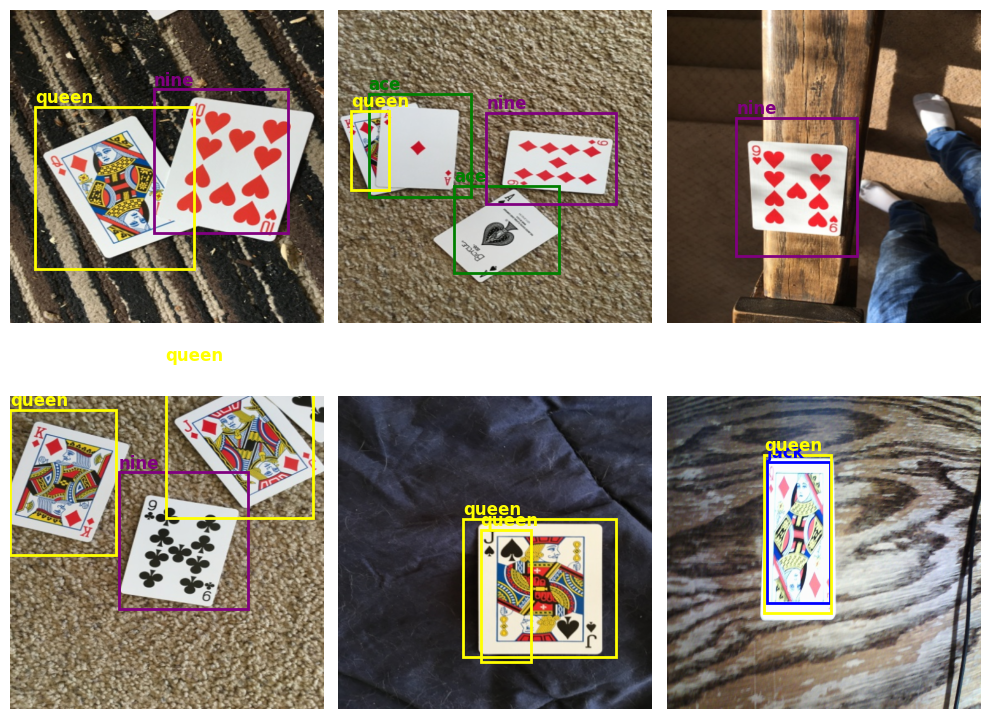

In [ ]:
bboxes = decode_prediction_nms(pred, threshold=0.1)
visualize(img.cpu(), bboxes)

Теперь возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO 11 от ultralytics.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.9 MB/s eta 0:00:00


Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат.

In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуем функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO 11. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.



In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    txt = []
    for bbox in bboxes:
        xmin, ymin, xmax, ymax, cls = bbox
        x_c = (xmin + xmax) / (2 * w_im)
        y_c = (ymin + ymax) / (2 * h_im)
        w = (xmax - xmin) / w_im
        h = (ymax - ymin) / h_im
        txt.append(f"{cls} {x_c} {y_c} {w} {h}")
    return txt

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики


for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0],
        "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0],
        "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc =  6
names = train_ds.class_dict_inv

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

Обучим модель YOLO 11 самого маленького размера.

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")
model.train(data="data.yaml", epochs=100, imgsz=512)


Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=T

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a0a6c7021b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")
pred = model.predict(source="valid/images", imgsz=320, conf=0.5, save=True)




image 1/37 /content/valid/images/IMG_2383.JPG: 320x256 1 ace, 213.5ms
image 2/37 /content/valid/images/IMG_2386.JPG: 320x256 1 ace, 33.8ms
image 3/37 /content/valid/images/IMG_2388.JPG: 320x256 1 king, 29.8ms
image 4/37 /content/valid/images/IMG_2394.JPG: 320x256 1 nine, 22.1ms
image 5/37 /content/valid/images/IMG_2407.JPG: 320x256 1 jack, 15.8ms
image 6/37 /content/valid/images/IMG_2408.JPG: 320x256 1 jack, 32.8ms
image 7/37 /content/valid/images/IMG_2411.JPG: 320x256 1 jack, 15.4ms
image 8/37 /content/valid/images/IMG_2413.JPG: 320x256 1 nine, 19.0ms
image 9/37 /content/valid/images/IMG_2456.JPG: 320x256 1 ten, 37.2ms
image 10/37 /content/valid/images/IMG_2459.JPG: 320x256 1 nine, 20.7ms
image 11/37 /content/valid/images/IMG_2473.JPG: 320x256 1 ace, 16.2ms
image 12/37 /content/valid/images/IMG_2477.JPG: 320x256 1 queen, 28.6ms
image 13/37 /content/valid/images/IMG_2478.JPG: 320x256 1 jack, 1 ten, 15.7ms
image 14/37 /content/valid/images/IMG_2503.JPG: 320x256 1 jack, 15.2ms
image 15/

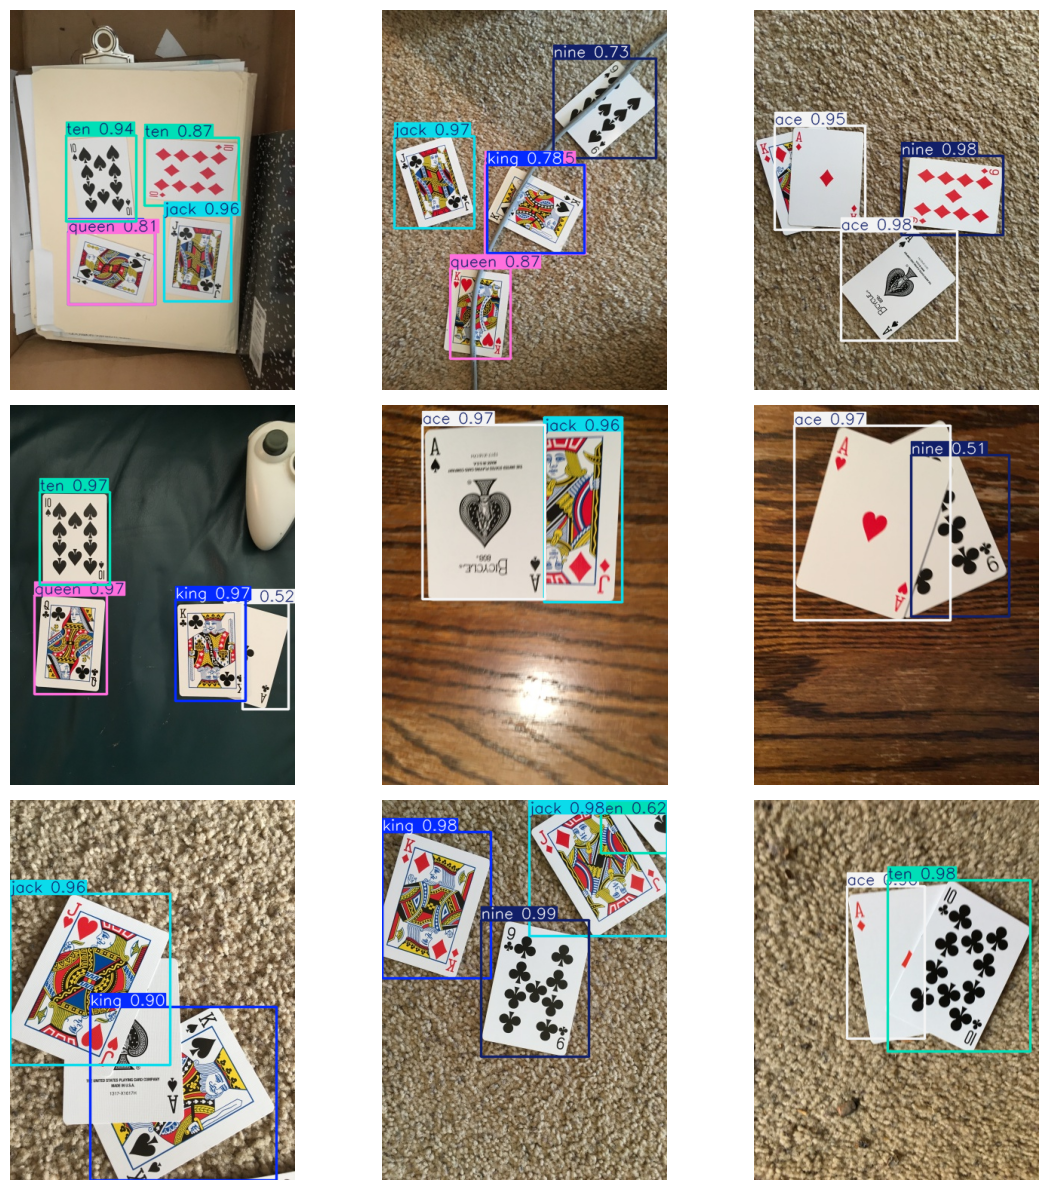

In [ ]:
imgs = [result.plot()[:, :, ::-1] for result in pred[16:26]]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for ax, img in zip(axes.flatten(), imgs):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

Крутые результаты!